# IERG 5350 Assignment 4: Advanced Algorithms for Continuous Control in RL

### Welcome to assignment 4 of our RL course!
*2020-2021 Term 1, IERG 5350: Reinforcement Learning. Department of Information Engineering, The Chinese University of Hong Kong. Course Instructor: Professor ZHOU Bolei. Assignment author: PENG Zhenghao, SUN Hao, ZHAN Xiaohang.*


| Student Name | Student ID |
| :----: | :----: |
| HUANG Zhaoyang | 1155152331 |

------


In this assignment, we will implement a system of RL that allows us to train and evaluate RL agents formally and efficiently.

In this notebook, you will go through the following components of the whole system:
- Preparation: Colab, and Environment
- Section 1: Training with algorithm PPO
- Section 2: Training with algorithm DDPG
- Section 3: Training with algorithm TD3
- Section 4: Transfer your PPO/ DDPG/ TD3 to another task: Four-Solution-Maze

The author of this assignment is SUN, Hao (sh018 AT ie.cuhk.edu.hk).

# Colab

### Introduction to Google Colab: 
From now on, our assignment as well as the final project will be based on the Google Colab, where you can apply for free GPU resources to accelerate the learning of your RL models. 

Here are some resources as intro to the Colab.

- YouTube Video: https://www.youtube.com/watch?v=inN8seMm7UI
- Colab Intro: https://colab.research.google.com/notebooks/intro.ipynb
(you may need to login with your google account)




# Gym Continuous Control Tasks

### Introduction to the Gym Continuous Control Envirionments

In the last assignment, you have already used the gym[atari] benchmarks, where the action space is discrete so that normal approach is value-based methods e.g., DQN.

In this assignment, we will try to implement three prevailing RL algorithms for continuous control tasks, namely the PPO(https://arxiv.org/abs/1707.06347), DDPG(https://arxiv.org/abs/1509.02971) and TD3(https://arxiv.org/abs/1802.09477).

We will now begin with a gym environment for continuous control,

The Pendulum-v0






In [1]:
import gym
ENV_NAME = "Pendulum-v0"
env = gym.make(ENV_NAME)
state = env.reset()
print('the state space is like', state)
print('the max and min action is: ',env.action_space.high,env.action_space.low)

'''so that you may need to use action value re-size if you want to use the tanh activation functions'''

the state space is like [0.99344123 0.11434389 0.64249418]
the max and min action is:  [2.] [-2.]


'so that you may need to use action value re-size if you want to use the tanh activation functions'

# PPO 

The Proximal Policy Optimization Algorithms is the most prevailing on-policy learning method. Although its sample efficiency is not as high as the off-policy methods, the PPO is relatively easy to implement and the learning is much more stable than off-policy methods. Whenever you have a task you want to try whether RL works, you may try to run a PPO agent at first. It is worth mentioning even the most challenging game, the StarCraftII agent AlphaStar is trained based on PPO (with lots of improvements, ofcourse).


## TODOs for You
The ppo has the benfitsof trust region policy optimization (TRPO) but is much simpler to implement, and with some implementation engeneering, the sample complexity of TRPO is further improved.

The key idea of PPO optimization is *Not Optimize the Policy Too Much in a Certain Step*, which follows the key insight of the method of TRPO.

In TRPO, the optimization objective of policy is to learn a policy such that 

$$\max_\theta \hat{\mathbb{E}}_t [\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\hat{A}_t]$$

subject to 

$$\hat{\mathbb{E}}_t[KL[\pi_{\theta_{old}}(\cdot|s_t),\pi_\theta(\cdot|s_t)]] \le \delta$$

where $\hat{A}$ denotes the advantage function, rather than optimize the objective function of 

$$L^{PG}(\theta) = \hat{\mathbb{E}}_t[\log \pi_\theta(a_t|s_t)\hat{A}_t]$$

in the normal policy gradint methods.

The PPO proposed two alternative approaches to solve the constrained optimization above, namely the Clipped Surrogated Objective and the Adaptive KL penalty Coefficient. The former one is more generally used in practice as it's more convenient to implement, more efficient and owns stable performance.

The Clipped Surrogated Objective approach replace the surrogate objective

$$L^{CPI}(\theta) = \hat{\mathbb{E}}_t[\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\hat{A}_t] = \hat{\mathbb{E}}_t[r_t(\theta)\hat{A}_t]$$

of TRPO (CPI: Conservative Policy Iteration) by 

$$L^{CLIP}(\theta) = \hat{\mathbb{E}}_t[\min(r_t(\theta)\hat{A}_t,clip(r_t(\theta),1-\epsilon, 1+\epsilon)\hat{A}_t)]$$

You can check that $L^{CLIP}(\theta) = L^{CPI}(\theta)$ around the old policy parameter $\theta_{old}$, i.e., when r = 1.

## TODOs here:

In this section, your task is to finish the code of a PPO algorithm and evaluate its performance in the Pendulum-v0 environment.

Specifically, you need to
- Q1. finish building up the ActorCritic ''\__init__'' function, i.e., build up the neural network.
- Q2. finish the foward function, in this part, there are two functions need to finish: the \_forward_actor function and the \_forward_critic function
- Q3. finish the select_action function, which is called during interacting with the environment, so that you may need to return an action as well as the (log-)probability of getting that action for future optimization
- Q4. finish the optimization steps for your PPO agent, that means you need to build up the surrogate loss through your saved tuples in previous episodes and optimize it with current network parameters.
- Q5. finally, you may need to optimize some of the hyper-parameters to have a better task performance. 

In [23]:
# You need not to rivese this unless you want to try other hyper-parameter settings
# in which case you may revise the default values of class args()
from IPython import display
import torch
import torch.nn as nn
import torch.optim as opt
from torch import Tensor
from torch.autograd import Variable
from collections import namedtuple
from itertools import count
import torch.nn.functional as F
import matplotlib.pyplot as plt
from os.path import join as joindir
from os import makedirs as mkdir
import pandas as pd
import numpy as np
import argparse
import datetime
import math
import random

Transition = namedtuple('Transition', ('state', 'value', 'action', 'logproba', 'mask', 'next_state', 'reward'))
env = gym.make(ENV_NAME)
env.reset()

EPS = 1e-10 # you may need this tiny value somewhere, and think about why?
RESULT_DIR = 'Result_PPO'
mkdir(RESULT_DIR, exist_ok=True)
mkdir(ENV_NAME.split('-')[0]+'/CheckPoints', exist_ok=True)
mkdir(ENV_NAME.split('-')[0]+'/Rwds', exist_ok=True)
rwds = []
rwds_history = []

class args(object):
    hid_num = 256
    drop_prob = 0.1
    env_name = ENV_NAME
    seed = 1234
    num_episode = 1000
    batch_size = 5120
#     batch_size = 10240
    max_step_per_round = 2000
    gamma = 0.995
    lamda = 0.9
    log_num_episode = 1
    num_epoch = 10
    minibatch_size = 256
#     minibatch_size = 512
    clip = 0.2
    loss_coeff_value = 0.5
    loss_coeff_entropy = 0.01
    lr = 3e-4
    num_parallel_run = 1
    # tricks
    schedule_adam = 'linear'
    schedule_clip = 'linear'
    layer_norm = True
    state_norm = True
    advantage_norm = True
    lossvalue_norm = True

In [24]:
# You need not to rivese this, these classes are used for normalization
class RunningStat(object):
    def __init__(self, shape):
        self._n = 0
        self._M = np.zeros(shape)
        self._S = np.zeros(shape)

    def push(self, x):
        x = np.asarray(x)
        assert x.shape == self._M.shape
        self._n += 1
        if self._n == 1:
            self._M[...] = x
        else:
            oldM = self._M.copy()
            self._M[...] = oldM + (x - oldM) / self._n
            self._S[...] = self._S + (x - oldM) * (x - self._M)

    @property
    def n(self):
        return self._n

    @property
    def mean(self):
        return self._M

    @property
    def var(self):
        return self._S / (self._n - 1) if self._n > 1 else np.square(self._M)

    @property
    def std(self):
        return np.sqrt(self.var)

    @property
    def shape(self):
        return self._M.shape


class ZFilter:
    """
    y = (x-mean)/std
    using running estimates of mean,std
    """

    def __init__(self, shape, demean=True, destd=True, clip=10.0):
        self.demean = demean
        self.destd = destd
        self.clip = clip

        self.rs = RunningStat(shape)

    def __call__(self, x, update=True):
        if update: self.rs.push(x)
        if self.demean:
            x = x - self.rs.mean
        if self.destd:
            x = x / (self.rs.std + 1e-8)
        if self.clip:
            x = np.clip(x, -self.clip, self.clip)
        return x

    def output_shape(self, input_space):
        return input_space.shape

In [25]:
# Here, you need to finish the first 5 tasks.
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, layer_norm=True):
        super(ActorCritic, self).__init__()
        '''
        Q1:
        Initialize your networks
        '''
        self.actor_fc1 = nn.Linear(num_inputs, args.hid_num)
        self.actor_fc2 = nn.Linear(args.hid_num, args.hid_num)
        self.actor_fc3 = nn.Linear(args.hid_num, num_outputs)
        self.actor_fc = nn.Sequential(
            self.actor_fc1,
            nn.ReLU(),
            self.actor_fc2,
            nn.ReLU(),
            self.actor_fc3,
            nn.Tanh()
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, num_outputs))

        self.critic_fc1 = nn.Linear(num_inputs, args.hid_num)
        self.critic_fc2 = nn.Linear(args.hid_num, args.hid_num)
        self.critic_fc3 = nn.Linear(args.hid_num, num_outputs)
        self.critic_fc = nn.Sequential(
            self.critic_fc1,
            nn.ReLU(),
            self.critic_fc2,
            nn.ReLU(),
            self.critic_fc3
        )

        if layer_norm:
            self.layer_norm(self.actor_fc1, std=1.0)
            self.layer_norm(self.actor_fc2, std=1.0)
            self.layer_norm(self.actor_fc3, std=0.01)

            self.layer_norm(self.critic_fc1, std=1.0)
            self.layer_norm(self.critic_fc2, std=1.0)
            self.layer_norm(self.critic_fc3, std=1.0)

    @staticmethod
    def layer_norm(layer, std=1.0, bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)

    def forward(self, states):
        """
        Q2.1:
        run policy network (actor) as well as value network (critic)
        :param states: a tensor represents states
        :return: 3 Tensor2
        your _forward_actor() function should return both the mean value of action and the log-standard deviation of the action
        """

        action_mean, action_logstd = self._forward_actor(states)
        critic_value = self._forward_critic(states)
        return action_mean, action_logstd, critic_value

    def _forward_actor(self, states):
        '''
        Q2.2:
        build something like 
        x = activation (actor_fc(state))
        the logstd output has already been provided
        '''
        action_mean = self.actor_fc(states) * 2 # [-2, 2]
        action_logstd = self.actor_logstd.expand_as(action_mean)
        return action_mean, action_logstd

    def _forward_critic(self, states):
        '''
        Q2.3:
        build something like 
        x = activation (critic_fc(state))'''

        critic_value = self.critic_fc(states)
        return critic_value

    def select_action(self, action_mean, action_logstd, return_logproba=True):
        """
        Q3.1:
        given mean and std, sample an action from normal(mean, std)
        also returns probability of the given chosen
        """
        
        D = torch.distributions.Normal(action_mean, torch.exp(action_logstd)+EPS)
        action = torch.clamp(D.sample(), -2, 2)
        logproba = D.log_prob(action)
        return action, logproba

    @staticmethod
    def _normal_logproba(x, mean, logstd, std=None):
        '''
        Q3.2:
        given a mean and logstd of a gaussian,
        calculate the log-probability of a given x'''

        D = torch.distributions.Normal(mean, torch.exp(logstd)+EPS)
        logproba = D.log_prob(x)
        
        return logproba.sum(1)

    def get_logproba(self, states, actions):
        """
        return probability of chosen the given actions under corresponding states of current network
        :param states: Tensor
        :param actions: Tensor
        """
        action_mean, action_logstd = self._forward_actor(states)
        action_mean = action_mean.cpu()
        action_logstd = action_logstd.cpu()
        logproba = self._normal_logproba(actions, action_mean, action_logstd)
        return logproba


class Memory(object):
    def __init__(self):
        self.memory = []

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self):
        return Transition(*zip(*self.memory))

    def __len__(self):
        return len(self.memory)

env = gym.make(ENV_NAME)  
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
network.train()
def ppo(args):
    env = gym.make(args.env_name)
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    env.seed(args.seed)
    torch.manual_seed(args.seed)

    network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
    optimizer = opt.Adam(network.parameters(), lr=args.lr)

    running_state = ZFilter((num_inputs,), clip=5.0)

    # record average 1-round cumulative reward in every episode
    reward_record = []
    global_steps = 0

    lr_now = args.lr
    clip_now = args.clip

    for i_episode in range(args.num_episode):
        # step1: perform current policy to collect trajectories
        # this is an on-policy method!
        memory = Memory()
        num_steps = 0
        reward_list = []
        len_list = []
        while num_steps < args.batch_size:
            state = env.reset()
            if args.state_norm:
                state = running_state(state)
            reward_sum = 0
            for t in range(args.max_step_per_round):
                action_mean, action_logstd, value = network(Tensor(state).unsqueeze(0))
                action, logproba = network.select_action(action_mean, action_logstd)
                action = action.cpu().data.numpy()[0]
                logproba = logproba.cpu().data.numpy()[0]
                next_state, reward, done, _ = env.step(action)

                reward_sum += reward
                if args.state_norm:
                    next_state = running_state(next_state)
                mask = 0 if done else 1

                memory.push(state, value, action, logproba, mask, next_state, reward)

                if done:
                    break

                state = next_state

            num_steps += (t + 1)
            global_steps += (t + 1)
            reward_list.append(reward_sum)
            len_list.append(t + 1)
        reward_record.append({
            'episode': i_episode, 
            'steps': global_steps, 
            'meanepreward': np.mean(reward_list), 
            'meaneplen': np.mean(len_list)})
        rwds.extend(reward_list)
        batch = memory.sample()
        batch_size = len(memory)

        # step2: extract variables from trajectories
        rewards = Tensor(batch.reward)
        values = Tensor(batch.value)
        masks = Tensor(batch.mask)
        actions = Tensor(batch.action)
        states = Tensor(batch.state)
        oldlogproba = Tensor(batch.logproba)

        returns = Tensor(batch_size)
        deltas = Tensor(batch_size)
        advantages = Tensor(batch_size)

        prev_return = 0
        prev_value = 0
        prev_advantage = 0
        for i in reversed(range(batch_size)):
            returns[i] = rewards[i] + args.gamma * prev_return * masks[i]
            deltas[i] = rewards[i] + args.gamma * prev_value * masks[i] - values[i]
            # ref: https://arxiv.org/pdf/1506.02438.pdf (generalization advantage estimate)
            advantages[i] = deltas[i] + args.gamma * args.lamda * prev_advantage * masks[i]

            prev_return = returns[i]
            prev_value = values[i]
            prev_advantage = advantages[i]
        if args.advantage_norm:
            advantages = (advantages - advantages.mean()) / (advantages.std() + EPS)

        for i_epoch in range(int(args.num_epoch * batch_size / args.minibatch_size)):
            # sample from current batch
            minibatch_ind = np.random.choice(batch_size, args.minibatch_size, replace=False)
            minibatch_states = states[minibatch_ind]
            minibatch_actions = actions[minibatch_ind]
            minibatch_oldlogproba = oldlogproba[minibatch_ind]
            minibatch_newlogproba = network.get_logproba(minibatch_states, minibatch_actions)
            minibatch_advantages = advantages[minibatch_ind]
            minibatch_returns = returns[minibatch_ind]
            minibatch_newvalues = network._forward_critic(minibatch_states).flatten()



            '''
            Q4: 

            HERE: 
            now you have the advantages, and log-probabilities (both pi_new and pi_old)
            you need to do optimization according to the CLIP loss
            
            '''
            r = torch.exp(minibatch_newlogproba - minibatch_oldlogproba)
            s1 = r * minibatch_advantages
            s2 = torch.clamp(r, 1 - clip_now, 1 + clip_now) * minibatch_advantages
            loss_surr = -torch.mean(torch.min(s1, s2))

            if args.lossvalue_norm:
                minibatch_return_6std = 6 * minibatch_returns.std()
                loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2)) / minibatch_return_6std
            else:
                loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2))

            loss_entropy = torch.mean(torch.exp(minibatch_newlogproba) * minibatch_newlogproba)

            total_loss = loss_surr + args.loss_coeff_value * loss_value + args.loss_coeff_entropy * loss_entropy
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        if args.schedule_clip == 'linear':
            ep_ratio = 1 - (i_episode / args.num_episode)
            clip_now = args.clip * ep_ratio

        if args.schedule_adam == 'linear':
            ep_ratio = 1 - (i_episode / args.num_episode)
            lr_now = args.lr * ep_ratio
            for g in optimizer.param_groups:
                g['lr'] = lr_now

        if i_episode % args.log_num_episode == 0:
            print('Finished episode: {} Reward: {:.4f} total_loss = {:.4f} = {:.4f} + {} * {:.4f} + {} * {:.4f}' \
                .format(i_episode, reward_record[-1]['meanepreward'], total_loss.data, loss_surr.data, args.loss_coeff_value, 
                loss_value.data, args.loss_coeff_entropy, loss_entropy.data))
            print('-----------------')

    return reward_record

def test(args):
    record_dfs = []
    for i in range(args.num_parallel_run):
        args.seed += 1
        reward_record = pd.DataFrame(ppo(args))
        reward_record['#parallel_run'] = i
        record_dfs.append(reward_record)
    record_dfs = pd.concat(record_dfs, axis=0)
    record_dfs.to_csv(joindir(RESULT_DIR, 'ppo-record-{}.csv'.format(args.env_name)))

if __name__ == '__main__':
    for envname in [ENV_NAME]:
        args.env_name = envname
        test(args)

torch.save(network.state_dict(),args.env_name.split('-')[0]+'/CheckPoints/checkpoint_hidden_{0}'.format(args.hid_num)) 
np.savetxt(args.env_name.split('-')[0]+'/Rwds/rwds_hidden_{0}'.format(args.hid_num),rwds)

Finished episode: 0 Reward: -1300.5992 total_loss = 75.6463 = 0.1669 + 0.5 * 150.9638 + 0.01 * -0.2432
-----------------
Finished episode: 1 Reward: -1306.5176 total_loss = 25.5704 = 0.1746 + 0.5 * 50.7983 + 0.01 * -0.3382
-----------------
Finished episode: 2 Reward: -1275.1845 total_loss = 20.5015 = -0.0560 + 0.5 * 41.1202 + 0.01 * -0.2625
-----------------
Finished episode: 3 Reward: -1330.6315 total_loss = 20.8473 = 0.1944 + 0.5 * 41.3108 + 0.01 * -0.2562
-----------------
Finished episode: 4 Reward: -1354.6451 total_loss = 20.9559 = 0.1728 + 0.5 * 41.5720 + 0.01 * -0.2902
-----------------
Finished episode: 5 Reward: -1256.0644 total_loss = 19.0352 = 0.0765 + 0.5 * 37.9240 + 0.01 * -0.3252
-----------------
Finished episode: 6 Reward: -1294.9929 total_loss = 19.4824 = 0.2743 + 0.5 * 38.4218 + 0.01 * -0.2796
-----------------
Finished episode: 7 Reward: -1192.6062 total_loss = 16.2362 = 0.0438 + 0.5 * 32.3911 + 0.01 * -0.3187
-----------------
Finished episode: 8 Reward: -1192.4326

Finished episode: 68 Reward: -1068.1527 total_loss = 10.3271 = -0.0284 + 0.5 * 20.7150 + 0.01 * -0.2043
-----------------
Finished episode: 69 Reward: -1043.3821 total_loss = 11.3795 = 0.0275 + 0.5 * 22.7081 + 0.01 * -0.2021
-----------------
Finished episode: 70 Reward: -1093.9854 total_loss = 13.0613 = -0.0480 + 0.5 * 26.2225 + 0.01 * -0.1989
-----------------
Finished episode: 71 Reward: -1025.2817 total_loss = 9.3093 = 0.0032 + 0.5 * 18.6163 + 0.01 * -0.2014
-----------------
Finished episode: 72 Reward: -1058.6795 total_loss = 12.5588 = 0.0403 + 0.5 * 25.0409 + 0.01 * -0.1999
-----------------
Finished episode: 73 Reward: -1020.8842 total_loss = 11.2235 = -0.0518 + 0.5 * 22.5547 + 0.01 * -0.2000
-----------------
Finished episode: 74 Reward: -935.6032 total_loss = 9.6573 = 0.0333 + 0.5 * 19.2520 + 0.01 * -0.1998
-----------------
Finished episode: 75 Reward: -984.7596 total_loss = 11.0845 = 0.0251 + 0.5 * 22.1227 + 0.01 * -0.1981
-----------------
Finished episode: 76 Reward: -105

Finished episode: 136 Reward: -1015.6561 total_loss = 8.5211 = -0.0558 + 0.5 * 17.1577 + 0.01 * -0.1924
-----------------
Finished episode: 137 Reward: -992.2951 total_loss = 8.5050 = 0.0019 + 0.5 * 17.0101 + 0.01 * -0.1891
-----------------
Finished episode: 138 Reward: -935.4265 total_loss = 10.8186 = 0.0065 + 0.5 * 21.6280 + 0.01 * -0.1875
-----------------
Finished episode: 139 Reward: -975.9290 total_loss = 9.6722 = 0.0183 + 0.5 * 19.3116 + 0.01 * -0.1892
-----------------
Finished episode: 140 Reward: -884.8585 total_loss = 8.9540 = -0.0845 + 0.5 * 18.0809 + 0.01 * -0.1894
-----------------
Finished episode: 141 Reward: -943.9329 total_loss = 8.4614 = 0.0277 + 0.5 * 16.8711 + 0.01 * -0.1911
-----------------
Finished episode: 142 Reward: -893.9038 total_loss = 8.5635 = 0.0385 + 0.5 * 17.0538 + 0.01 * -0.1897
-----------------
Finished episode: 143 Reward: -982.4217 total_loss = 8.8867 = -0.0705 + 0.5 * 17.9181 + 0.01 * -0.1874
-----------------
Finished episode: 144 Reward: -974.

Finished episode: 204 Reward: -896.4065 total_loss = 8.1309 = -0.0135 + 0.5 * 16.2928 + 0.01 * -0.1915
-----------------
Finished episode: 205 Reward: -954.1396 total_loss = 7.7445 = -0.1366 + 0.5 * 15.7661 + 0.01 * -0.1911
-----------------
Finished episode: 206 Reward: -861.1821 total_loss = 7.1186 = -0.0797 + 0.5 * 14.4003 + 0.01 * -0.1908
-----------------
Finished episode: 207 Reward: -971.0786 total_loss = 10.1148 = -0.0259 + 0.5 * 20.2852 + 0.01 * -0.1908
-----------------
Finished episode: 208 Reward: -946.7436 total_loss = 10.0227 = 0.0618 + 0.5 * 19.9256 + 0.01 * -0.1875
-----------------
Finished episode: 209 Reward: -922.4291 total_loss = 9.4122 = 0.0554 + 0.5 * 18.7173 + 0.01 * -0.1881
-----------------
Finished episode: 210 Reward: -1016.3100 total_loss = 11.2599 = -0.0344 + 0.5 * 22.5923 + 0.01 * -0.1886
-----------------
Finished episode: 211 Reward: -867.2027 total_loss = 6.9718 = 0.0042 + 0.5 * 13.9391 + 0.01 * -0.1886
-----------------
Finished episode: 212 Reward: -

Finished episode: 272 Reward: -1015.7239 total_loss = 8.4888 = -0.0082 + 0.5 * 16.9976 + 0.01 * -0.1844
-----------------
Finished episode: 273 Reward: -956.1271 total_loss = 9.1517 = -0.0448 + 0.5 * 18.3965 + 0.01 * -0.1845
-----------------
Finished episode: 274 Reward: -1015.6025 total_loss = 7.4000 = 0.0530 + 0.5 * 14.6977 + 0.01 * -0.1862
-----------------
Finished episode: 275 Reward: -897.0848 total_loss = 10.8582 = -0.0636 + 0.5 * 21.8474 + 0.01 * -0.1851
-----------------
Finished episode: 276 Reward: -903.1894 total_loss = 7.4659 = -0.2128 + 0.5 * 15.3611 + 0.01 * -0.1855
-----------------
Finished episode: 277 Reward: -1006.9353 total_loss = 10.3226 = -0.0109 + 0.5 * 20.6707 + 0.01 * -0.1862
-----------------
Finished episode: 278 Reward: -953.6732 total_loss = 10.8808 = -0.1012 + 0.5 * 21.9677 + 0.01 * -0.1870
-----------------
Finished episode: 279 Reward: -1026.0048 total_loss = 10.0250 = -0.1375 + 0.5 * 20.3288 + 0.01 * -0.1869
-----------------
Finished episode: 280 Rew

Finished episode: 340 Reward: -783.7957 total_loss = 9.4085 = 0.0301 + 0.5 * 18.7607 + 0.01 * -0.2010
-----------------
Finished episode: 341 Reward: -832.1103 total_loss = 7.9940 = 0.0150 + 0.5 * 15.9621 + 0.01 * -0.2024
-----------------
Finished episode: 342 Reward: -864.1712 total_loss = 9.1385 = -0.0234 + 0.5 * 18.3279 + 0.01 * -0.2027
-----------------
Finished episode: 343 Reward: -1008.2935 total_loss = 8.3201 = -0.0133 + 0.5 * 16.6709 + 0.01 * -0.2002
-----------------
Finished episode: 344 Reward: -835.3605 total_loss = 9.2674 = 0.0519 + 0.5 * 18.4351 + 0.01 * -0.2023
-----------------
Finished episode: 345 Reward: -930.5178 total_loss = 8.0626 = -0.0161 + 0.5 * 16.1615 + 0.01 * -0.2035
-----------------
Finished episode: 346 Reward: -877.6673 total_loss = 8.9137 = 0.0421 + 0.5 * 17.7473 + 0.01 * -0.2015
-----------------
Finished episode: 347 Reward: -892.3168 total_loss = 8.4255 = -0.0019 + 0.5 * 16.8590 + 0.01 * -0.2021
-----------------
Finished episode: 348 Reward: -886.

Finished episode: 408 Reward: -946.5218 total_loss = 7.0013 = -0.0133 + 0.5 * 14.0332 + 0.01 * -0.2008
-----------------
Finished episode: 409 Reward: -905.4894 total_loss = 6.7558 = 0.0496 + 0.5 * 13.4165 + 0.01 * -0.2005
-----------------
Finished episode: 410 Reward: -963.8491 total_loss = 8.9576 = -0.0086 + 0.5 * 17.9363 + 0.01 * -0.1995
-----------------
Finished episode: 411 Reward: -898.8858 total_loss = 8.1113 = 0.0996 + 0.5 * 16.0273 + 0.01 * -0.1990
-----------------
Finished episode: 412 Reward: -931.4079 total_loss = 9.1617 = 0.0411 + 0.5 * 18.2451 + 0.01 * -0.1995
-----------------
Finished episode: 413 Reward: -930.3701 total_loss = 8.6109 = -0.1115 + 0.5 * 17.4488 + 0.01 * -0.1996
-----------------
Finished episode: 414 Reward: -921.7602 total_loss = 8.7258 = 0.0351 + 0.5 * 17.3855 + 0.01 * -0.1999
-----------------
Finished episode: 415 Reward: -921.8716 total_loss = 9.7305 = -0.0804 + 0.5 * 19.6259 + 0.01 * -0.2006
-----------------
Finished episode: 416 Reward: -943.0

Finished episode: 476 Reward: -921.3841 total_loss = 7.1381 = -0.0040 + 0.5 * 14.2882 + 0.01 * -0.2043
-----------------
Finished episode: 477 Reward: -902.6110 total_loss = 7.4433 = 0.0294 + 0.5 * 14.8319 + 0.01 * -0.2037
-----------------
Finished episode: 478 Reward: -889.2508 total_loss = 7.5566 = 0.0402 + 0.5 * 15.0369 + 0.01 * -0.2053
-----------------
Finished episode: 479 Reward: -942.1231 total_loss = 7.0602 = -0.0850 + 0.5 * 14.2946 + 0.01 * -0.2042
-----------------
Finished episode: 480 Reward: -969.2881 total_loss = 7.4152 = -0.0070 + 0.5 * 14.8485 + 0.01 * -0.2027
-----------------
Finished episode: 481 Reward: -924.5879 total_loss = 10.2415 = -0.0583 + 0.5 * 20.6037 + 0.01 * -0.2041
-----------------
Finished episode: 482 Reward: -913.7627 total_loss = 8.9385 = -0.0348 + 0.5 * 17.9507 + 0.01 * -0.2034
-----------------
Finished episode: 483 Reward: -922.3230 total_loss = 8.8817 = -0.0241 + 0.5 * 17.8156 + 0.01 * -0.2036
-----------------
Finished episode: 484 Reward: -90

Finished episode: 544 Reward: -945.6641 total_loss = 10.5577 = -0.0307 + 0.5 * 21.1810 + 0.01 * -0.2065
-----------------
Finished episode: 545 Reward: -929.4354 total_loss = 9.7358 = 0.0333 + 0.5 * 19.4091 + 0.01 * -0.2081
-----------------
Finished episode: 546 Reward: -903.9882 total_loss = 9.3319 = -0.0338 + 0.5 * 18.7356 + 0.01 * -0.2065
-----------------
Finished episode: 547 Reward: -986.6851 total_loss = 10.2854 = -0.0073 + 0.5 * 20.5896 + 0.01 * -0.2066
-----------------
Finished episode: 548 Reward: -958.1843 total_loss = 12.0257 = 0.0025 + 0.5 * 24.0504 + 0.01 * -0.2066
-----------------
Finished episode: 549 Reward: -943.7803 total_loss = 9.6187 = 0.0673 + 0.5 * 19.1069 + 0.01 * -0.2058
-----------------
Finished episode: 550 Reward: -911.8739 total_loss = 9.5033 = 0.0176 + 0.5 * 18.9753 + 0.01 * -0.2057
-----------------
Finished episode: 551 Reward: -995.4586 total_loss = 9.0289 = -0.0399 + 0.5 * 18.1416 + 0.01 * -0.2049
-----------------
Finished episode: 552 Reward: -99

Finished episode: 612 Reward: -954.8995 total_loss = 9.1617 = -0.0143 + 0.5 * 18.3561 + 0.01 * -0.2032
-----------------
Finished episode: 613 Reward: -956.9004 total_loss = 10.7530 = -0.0382 + 0.5 * 21.5864 + 0.01 * -0.2028
-----------------
Finished episode: 614 Reward: -968.0407 total_loss = 9.2849 = 0.0398 + 0.5 * 18.4941 + 0.01 * -0.2025
-----------------
Finished episode: 615 Reward: -908.4820 total_loss = 9.0367 = -0.0424 + 0.5 * 18.1623 + 0.01 * -0.2038
-----------------
Finished episode: 616 Reward: -925.5572 total_loss = 10.1670 = 0.0975 + 0.5 * 20.1430 + 0.01 * -0.2039
-----------------
Finished episode: 617 Reward: -966.8928 total_loss = 9.0985 = 0.1248 + 0.5 * 17.9513 + 0.01 * -0.2026
-----------------
Finished episode: 618 Reward: -976.5394 total_loss = 10.2060 = -0.0803 + 0.5 * 20.5766 + 0.01 * -0.2037
-----------------
Finished episode: 619 Reward: -930.5230 total_loss = 9.3627 = 0.1067 + 0.5 * 18.5161 + 0.01 * -0.2031
-----------------
Finished episode: 620 Reward: -89

Finished episode: 680 Reward: -979.1627 total_loss = 8.2047 = 0.0503 + 0.5 * 16.3128 + 0.01 * -0.2011
-----------------
Finished episode: 681 Reward: -1001.9501 total_loss = 11.7639 = -0.0282 + 0.5 * 23.5882 + 0.01 * -0.2019
-----------------
Finished episode: 682 Reward: -982.9258 total_loss = 9.9019 = -0.0469 + 0.5 * 19.9015 + 0.01 * -0.2008
-----------------
Finished episode: 683 Reward: -1009.3097 total_loss = 10.5267 = -0.0071 + 0.5 * 21.0717 + 0.01 * -0.2018
-----------------
Finished episode: 684 Reward: -966.0409 total_loss = 9.4769 = 0.0676 + 0.5 * 18.8226 + 0.01 * -0.2017
-----------------
Finished episode: 685 Reward: -961.6917 total_loss = 8.6882 = 0.0463 + 0.5 * 17.2878 + 0.01 * -0.2016
-----------------
Finished episode: 686 Reward: -945.3526 total_loss = 8.5847 = 0.1007 + 0.5 * 16.9721 + 0.01 * -0.2006
-----------------
Finished episode: 687 Reward: -1033.9137 total_loss = 10.7329 = -0.0263 + 0.5 * 21.5225 + 0.01 * -0.2011
-----------------
Finished episode: 688 Reward: 

Finished episode: 748 Reward: -955.8878 total_loss = 9.6672 = -0.0338 + 0.5 * 19.4062 + 0.01 * -0.2014
-----------------
Finished episode: 749 Reward: -1012.1188 total_loss = 10.6350 = -0.0933 + 0.5 * 21.4606 + 0.01 * -0.2011
-----------------
Finished episode: 750 Reward: -1037.1851 total_loss = 8.2455 = 0.0372 + 0.5 * 16.4206 + 0.01 * -0.2006
-----------------
Finished episode: 751 Reward: -981.5060 total_loss = 9.3491 = -0.0377 + 0.5 * 18.7776 + 0.01 * -0.2019
-----------------
Finished episode: 752 Reward: -996.1754 total_loss = 10.6187 = 0.0070 + 0.5 * 21.2273 + 0.01 * -0.2004
-----------------
Finished episode: 753 Reward: -1014.3536 total_loss = 9.9199 = 0.0977 + 0.5 * 19.6484 + 0.01 * -0.2007
-----------------
Finished episode: 754 Reward: -1046.3428 total_loss = 9.4356 = 0.0091 + 0.5 * 18.8569 + 0.01 * -0.2013
-----------------
Finished episode: 755 Reward: -1002.7620 total_loss = 10.2124 = 0.0114 + 0.5 * 20.4058 + 0.01 * -0.1998
-----------------
Finished episode: 756 Reward:

Finished episode: 816 Reward: -1100.7885 total_loss = 8.1767 = -0.0623 + 0.5 * 16.4819 + 0.01 * -0.1989
-----------------
Finished episode: 817 Reward: -1088.0240 total_loss = 8.1036 = -0.1048 + 0.5 * 16.4208 + 0.01 * -0.1991
-----------------
Finished episode: 818 Reward: -1066.0966 total_loss = 8.0532 = 0.0682 + 0.5 * 15.9740 + 0.01 * -0.1985
-----------------
Finished episode: 819 Reward: -1050.1435 total_loss = 9.3189 = -0.0077 + 0.5 * 18.6571 + 0.01 * -0.1986
-----------------
Finished episode: 820 Reward: -1027.5868 total_loss = 12.1347 = -0.0565 + 0.5 * 24.3864 + 0.01 * -0.1983
-----------------
Finished episode: 821 Reward: -1043.1729 total_loss = 10.8990 = 0.0286 + 0.5 * 21.7447 + 0.01 * -0.1985
-----------------
Finished episode: 822 Reward: -1059.7141 total_loss = 10.2747 = -0.0036 + 0.5 * 20.5605 + 0.01 * -0.1977
-----------------
Finished episode: 823 Reward: -962.2310 total_loss = 11.2287 = 0.0383 + 0.5 * 22.3847 + 0.01 * -0.1980
-----------------
Finished episode: 824 Re

Finished episode: 883 Reward: -1173.7433 total_loss = 16.0021 = 0.0107 + 0.5 * 31.9867 + 0.01 * -0.1951
-----------------
Finished episode: 884 Reward: -1178.1972 total_loss = 15.2615 = -0.0311 + 0.5 * 30.5892 + 0.01 * -0.1956
-----------------
Finished episode: 885 Reward: -1202.8844 total_loss = 15.2613 = 0.0128 + 0.5 * 30.5010 + 0.01 * -0.1950
-----------------
Finished episode: 886 Reward: -1145.6037 total_loss = 13.6880 = 0.0907 + 0.5 * 27.1984 + 0.01 * -0.1955
-----------------
Finished episode: 887 Reward: -1103.1397 total_loss = 15.5783 = -0.1445 + 0.5 * 31.4496 + 0.01 * -0.1953
-----------------
Finished episode: 888 Reward: -1113.6866 total_loss = 14.3704 = -0.0195 + 0.5 * 28.7837 + 0.01 * -0.1950
-----------------
Finished episode: 889 Reward: -1086.9363 total_loss = 12.7669 = 0.0574 + 0.5 * 25.4228 + 0.01 * -0.1952
-----------------
Finished episode: 890 Reward: -1166.3235 total_loss = 15.1953 = 0.0647 + 0.5 * 30.2650 + 0.01 * -0.1948
-----------------
Finished episode: 891

Finished episode: 950 Reward: -1200.2054 total_loss = 15.9862 = 0.0390 + 0.5 * 31.8982 + 0.01 * -0.1923
-----------------
Finished episode: 951 Reward: -1121.3748 total_loss = 13.9739 = 0.0285 + 0.5 * 27.8947 + 0.01 * -0.1923
-----------------
Finished episode: 952 Reward: -1191.4676 total_loss = 14.5934 = 0.0807 + 0.5 * 29.0292 + 0.01 * -0.1924
-----------------
Finished episode: 953 Reward: -1175.5378 total_loss = 15.7380 = -0.0185 + 0.5 * 31.5167 + 0.01 * -0.1925
-----------------
Finished episode: 954 Reward: -1134.5522 total_loss = 15.3083 = -0.0361 + 0.5 * 30.6927 + 0.01 * -0.1928
-----------------
Finished episode: 955 Reward: -1258.1683 total_loss = 16.1245 = 0.0790 + 0.5 * 32.0949 + 0.01 * -0.1922
-----------------
Finished episode: 956 Reward: -1139.6217 total_loss = 15.1223 = -0.0586 + 0.5 * 30.3656 + 0.01 * -0.1920
-----------------
Finished episode: 957 Reward: -1236.0511 total_loss = 17.1138 = -0.0088 + 0.5 * 34.2490 + 0.01 * -0.1920
-----------------
Finished episode: 95

# DDPG and TD3

The Deterministic Policy Gradient method was proposed by Silver et. al. 2014 (http://proceedings.mlr.press/v32/silver14.pdf), and DDPG is its deep version.

The DPG also uses the actor-critic paradigm, but maitains a deterministic version of policy. It optimizes the critic through the Bellman Equation, and optimize the actor through the chain rule. 

In this assignment, you may need to import some python files like DDPG.py and TD3.py to insert the method into training.
Here are some solutions from stackoverflow: https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab.

It is easier to just copy it from Drive than upload it.
1. Store MYLIB.py in your Drive. (for this assignment, it will be the utils.py, DDPG.py and TD3.py)
2. Open the Colab.
3. Open the left side pane, select Files view (the file icon).
4. Click Mount Drive then Connect to Google Drive (the folder with google drive icon).
5. Copy it by running "! cp drive/My\ Drive/MYLIB.py . " in your Colab file code line.
6. import MYLIB




## TODOs for You (Please write down the answer in this block)

The TD3 is short for *Twin Delayed Deep Deterministic Policy Gradient*, their official open-source implementation is extremely clear and easy to follow! So I believe there is no need for you to build up the wheels one more time.

However, you really need to know about how this method works!
TD3 proposes several improvements based on the method of DDPG to improve its sample efficiency.

- Q6. In this part, your task is to read the paper, and read the code of the official implementation of TD3 and DDPG at:

https://github.com/sfujim/TD3/blob/master/DDPG.py

https://github.com/sfujim/TD3/blob/master/TD3.py

Then, please try to find the proposed improvements in TD3 over DDPG and summary them HERE:


1. Delay the policy network update frequency
    - code:
    ```
    		# Delayed policy updates
		if self.total_it % self.policy_freq == 0:
    ```
2. Double-Q learning to reduce the overestimation of Q-values
    - code:
    ```
			target_Q1, target_Q2 = self.critic_target(next_state, next_action)
			target_Q = torch.min(target_Q1, target_Q2)
    ```
3. Use noised action to smooth the target policy
    - code:
    ```
			noise = (
				torch.randn_like(action) * self.policy_noise
			).clamp(-self.noise_clip, self.noise_clip)
			
			next_action = (
				self.actor_target(next_state) + noise
			).clamp(-self.max_action, self.max_action)
    ```
4. Compute the critic loss from both of the two Q networks
    - code:
    ```
    		critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
    ```

- Q7. Among all those improvements, which do you believe is the most important one? You may take some ablation studies to support your claim.  (i.e., draw some learning curves with different settings together and draw your conclusions)

- Q8. What is the difference between TD3(DDPG) and PPO in the OPTIMIZATION step (including but not restricted in terms of the sampling-training proportion)? Actually the improvements of PPO over TRPO was pointed  as a benefit of more training iterations, can you further improve the sample efficiency of TD3?


```
A8: 
1. The optimization of PPO is based on the advantage value, which is computed from the state value function, while TD3(DDPG) is based on the Q function.
2. PPO train the networks with multiple epoches once sampled, while TD3 only train once with each sample. Therefore PPO can do more training efforts. We can also applie this strategy to TD3.
3. PPO use an online policy but TD3/DDPG use an offline policy.
```

- Q9. (i) Please describe the difference of the exploration strategies between PPO, DDPG and TD3. (ii) Provide a comparison between the exploration strategies of those continuous control algorithms and DQN.


(i)

PPO: sample an action from the normal distribution that centered at action_mean.

DDPG: either use the optimal action or sample an action uniformly in the action space.
TD3: Further add an gaussian noise to the selected action based on DDPG.

(ii)
DQN: 1) Use epsilon-greedy algorithm that uniformly sample a categorical action with an epsilon probability. 2) Use a target Q function when training to reduce variance.

DDPG/TD3: 1) Compared with DQN, it samples the actionfrom a continuous space $a_{TD3} \in R^n$  rather than a discrete space $a_{DQN} \in Z^+$. 2) DQN and DDPG/TD3 both use the target Q function when training.

- Q10. (Bonus, 20 points) An open question. Do you think an epsilon-greedy-like exploration strategy you used in DQN/Q-learning is useful for continuous control? Will there be any problem of applying epsilon-greedy method in DDPG/TD3/PPO? Try to implement the idea and report the results.

The following four blocks download the code in official implementation to your google drive so that the following script can run them. Note that the downloaded files may disappear due to some colab mechansim.

In [ ]:
!git clone https://github.com/sfujim/TD3.git

In [2]:
!cp TD3/DDPG.py .

In [3]:
!cp TD3/TD3.py .

In [4]:
!cp TD3/utils.py .

In [8]:
from os import makedirs as mkdir
mkdir('results', exist_ok=True)

In [9]:
# The following scripts run the DDPG algorithm.

alias = 'ddpg' # an alias of your experiment, used as a label


import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import argparse
import os
import torch.nn.functional as F
import utils
import TD3
import DDPG

def eval_policy(policy, eval_episodes=10):
    eval_env = gym.make(ENV_NAME)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done,_ = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes
    #print("---------------------------------------")
    #print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    #print("---------------------------------------")
    return avg_reward

env = gym.make(ENV_NAME)
torch.manual_seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]

args_policy_noise = 0.2
args_noise_clip = 0.5
args_policy_freq = 2
args_max_timesteps = 100000
args_expl_noise = 0.1
args_batch_size = 25
args_eval_freq = 1000
args_start_timesteps = 0

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": 0.99,
    "tau": 0.005
}


args_policy = 'DDPG'

if args_policy == "TD3":
    # Target policy smoothing is scaled wrt the action scale
    kwargs["policy_noise"] = args_policy_noise * max_action
    kwargs["noise_clip"] = args_noise_clip * max_action
    kwargs["policy_freq"] = args_policy_freq
    policy = TD3.TD3(**kwargs)
elif args_policy == "DDPG":
    policy = DDPG.DDPG(**kwargs)
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy)]

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
counter = 0
msk_list = []        
temp_curve = [eval_policy(policy)]
temp_val = []
for t in range(int(args_max_timesteps)):
    episode_timesteps += 1
    counter += 1
    # Select action randomly or according to policy
    if t < args_start_timesteps:
        action = np.random.uniform(-max_action,max_action,action_dim)
    else:
        if np.random.uniform(0,1) < 0.1:
            action = np.random.uniform(-max_action,max_action,action_dim)
        else:
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * args_expl_noise, size=action_dim)
            ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done,_ = env.step(action) 
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    if t >= args_start_timesteps:
        '''TD3'''
        last_val = 999.
        patient = 5
        for i in range(1):
            policy.train(replay_buffer, args_batch_size)
                

    # Train agent after collecting sufficient data
    if done: 
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        msk_list = []
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % args_eval_freq == 0:
        evaluations.append(eval_policy(policy))
        print('recent Evaluation:',evaluations[-1])
        np.save('results/evaluations_alias{}_ENV{}'.format(alias,ENV_NAME),evaluations)

Total T: 200 Episode Num: 1 Episode T: 200 Reward: -1514.878
Total T: 400 Episode Num: 2 Episode T: 200 Reward: -1448.276
Total T: 600 Episode Num: 3 Episode T: 200 Reward: -1390.877
Total T: 800 Episode Num: 4 Episode T: 200 Reward: -1509.185
Total T: 1000 Episode Num: 5 Episode T: 200 Reward: -1575.625
recent Evaluation: -1414.6877126206898
Total T: 1200 Episode Num: 6 Episode T: 200 Reward: -1514.355
Total T: 1400 Episode Num: 7 Episode T: 200 Reward: -1602.583
Total T: 1600 Episode Num: 8 Episode T: 200 Reward: -1555.670
Total T: 1800 Episode Num: 9 Episode T: 200 Reward: -1408.073
Total T: 2000 Episode Num: 10 Episode T: 200 Reward: -1457.917
recent Evaluation: -1257.1985194271979
Total T: 2200 Episode Num: 11 Episode T: 200 Reward: -1263.587
Total T: 2400 Episode Num: 12 Episode T: 200 Reward: -1185.657
Total T: 2600 Episode Num: 13 Episode T: 200 Reward: -1079.949
Total T: 2800 Episode Num: 14 Episode T: 200 Reward: -1030.095
Total T: 3000 Episode Num: 15 Episode T: 200 Reward: 

Total T: 23600 Episode Num: 118 Episode T: 200 Reward: -117.265
Total T: 23800 Episode Num: 119 Episode T: 200 Reward: -353.471
Total T: 24000 Episode Num: 120 Episode T: 200 Reward: -120.831
recent Evaluation: -123.73558012844316
Total T: 24200 Episode Num: 121 Episode T: 200 Reward: -127.234
Total T: 24400 Episode Num: 122 Episode T: 200 Reward: -117.895
Total T: 24600 Episode Num: 123 Episode T: 200 Reward: -121.637
Total T: 24800 Episode Num: 124 Episode T: 200 Reward: -126.568
Total T: 25000 Episode Num: 125 Episode T: 200 Reward: -234.141
recent Evaluation: -133.3020174099737
Total T: 25200 Episode Num: 126 Episode T: 200 Reward: -365.004
Total T: 25400 Episode Num: 127 Episode T: 200 Reward: -115.620
Total T: 25600 Episode Num: 128 Episode T: 200 Reward: -1.717
Total T: 25800 Episode Num: 129 Episode T: 200 Reward: -118.602
Total T: 26000 Episode Num: 130 Episode T: 200 Reward: -119.785
recent Evaluation: -157.46882118705662
Total T: 26200 Episode Num: 131 Episode T: 200 Reward:

Total T: 46600 Episode Num: 233 Episode T: 200 Reward: -305.849
Total T: 46800 Episode Num: 234 Episode T: 200 Reward: -126.534
Total T: 47000 Episode Num: 235 Episode T: 200 Reward: -1.081
recent Evaluation: -191.33812408344167
Total T: 47200 Episode Num: 236 Episode T: 200 Reward: -121.116
Total T: 47400 Episode Num: 237 Episode T: 200 Reward: -118.637
Total T: 47600 Episode Num: 238 Episode T: 200 Reward: -243.419
Total T: 47800 Episode Num: 239 Episode T: 200 Reward: -114.245
Total T: 48000 Episode Num: 240 Episode T: 200 Reward: -240.785
recent Evaluation: -193.95946099086848
Total T: 48200 Episode Num: 241 Episode T: 200 Reward: -122.227
Total T: 48400 Episode Num: 242 Episode T: 200 Reward: -119.180
Total T: 48600 Episode Num: 243 Episode T: 200 Reward: -122.883
Total T: 48800 Episode Num: 244 Episode T: 200 Reward: -121.227
Total T: 49000 Episode Num: 245 Episode T: 200 Reward: -1.432
recent Evaluation: -122.34200580331556
Total T: 49200 Episode Num: 246 Episode T: 200 Reward: 

Total T: 69600 Episode Num: 348 Episode T: 200 Reward: -119.364
Total T: 69800 Episode Num: 349 Episode T: 200 Reward: -1.199
Total T: 70000 Episode Num: 350 Episode T: 200 Reward: -244.291
recent Evaluation: -132.0543874007601
Total T: 70200 Episode Num: 351 Episode T: 200 Reward: -119.988
Total T: 70400 Episode Num: 352 Episode T: 200 Reward: -122.893
Total T: 70600 Episode Num: 353 Episode T: 200 Reward: -247.563
Total T: 70800 Episode Num: 354 Episode T: 200 Reward: -122.230
Total T: 71000 Episode Num: 355 Episode T: 200 Reward: -238.401
recent Evaluation: -97.03254072458876
Total T: 71200 Episode Num: 356 Episode T: 200 Reward: -119.228
Total T: 71400 Episode Num: 357 Episode T: 200 Reward: -238.424
Total T: 71600 Episode Num: 358 Episode T: 200 Reward: -120.896
Total T: 71800 Episode Num: 359 Episode T: 200 Reward: -234.536
Total T: 72000 Episode Num: 360 Episode T: 200 Reward: -377.734
recent Evaluation: -131.6689400999754
Total T: 72200 Episode Num: 361 Episode T: 200 Reward: -

Total T: 92600 Episode Num: 463 Episode T: 200 Reward: -127.560
Total T: 92800 Episode Num: 464 Episode T: 200 Reward: -119.656
Total T: 93000 Episode Num: 465 Episode T: 200 Reward: -255.179
recent Evaluation: -144.83055500369113
Total T: 93200 Episode Num: 466 Episode T: 200 Reward: -250.432
Total T: 93400 Episode Num: 467 Episode T: 200 Reward: -349.822
Total T: 93600 Episode Num: 468 Episode T: 200 Reward: -123.375
Total T: 93800 Episode Num: 469 Episode T: 200 Reward: -121.372
Total T: 94000 Episode Num: 470 Episode T: 200 Reward: -234.942
recent Evaluation: -219.65795159696592
Total T: 94200 Episode Num: 471 Episode T: 200 Reward: -236.889
Total T: 94400 Episode Num: 472 Episode T: 200 Reward: -120.506
Total T: 94600 Episode Num: 473 Episode T: 200 Reward: -239.806
Total T: 94800 Episode Num: 474 Episode T: 200 Reward: -369.585
Total T: 95000 Episode Num: 475 Episode T: 200 Reward: -130.987
recent Evaluation: -134.32384092803673
Total T: 95200 Episode Num: 476 Episode T: 200 Rewa

In [10]:
# The following scripts run the TD3 algorithm.

alias = 'td3'


import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import argparse
import os
import torch.nn.functional as F
import utils
import TD3
import DDPG

def eval_policy(policy, eval_episodes=10):
    eval_env = gym.make(ENV_NAME)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done,_ = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes
    #print("---------------------------------------")
    #print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    #print("---------------------------------------")
    return avg_reward

env = gym.make(ENV_NAME)
torch.manual_seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]

args_policy_noise = 0.2
args_noise_clip = 0.5
args_policy_freq = 2
args_max_timesteps = 100000
args_expl_noise = 0.1
args_batch_size = 25
args_eval_freq = 1000
args_start_timesteps = 0

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": 0.99,
    "tau": 0.005
}


args_policy = 'TD3'

if args_policy == "TD3":
    # Target policy smoothing is scaled wrt the action scale
    kwargs["policy_noise"] = args_policy_noise * max_action
    kwargs["noise_clip"] = args_noise_clip * max_action
    kwargs["policy_freq"] = args_policy_freq
    policy = TD3.TD3(**kwargs)
elif args_policy == "OurDDPG":
    policy = OurDDPG.DDPG(**kwargs)
elif args_policy == "DDPG":
    policy = DDPG.DDPG(**kwargs)
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy)]

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
counter = 0
msk_list = []        
temp_curve = [eval_policy(policy)]
temp_val = []
for t in range(int(args_max_timesteps)):
    episode_timesteps += 1
    counter += 1
    # Select action randomly or according to policy
    if t < args_start_timesteps:
        action = np.random.uniform(-max_action,max_action,action_dim)
    else:
        if np.random.uniform(0,1) < 0.1:
            action = np.random.uniform(-max_action,max_action,action_dim)
        else:
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * args_expl_noise, size=action_dim)
            ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done,_ = env.step(action)
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    if t >= args_start_timesteps:
        '''TD3'''
        last_val = 999.
        patient = 5
        for i in range(1):
            policy.train(replay_buffer, args_batch_size)
                

    # Train agent after collecting sufficient data
    if done: 
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        msk_list = []
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % args_eval_freq == 0:
        evaluations.append(eval_policy(policy))
        print('recent Evaluation:',evaluations[-1])
        np.save('results/evaluations_alias{}_ENV{}'.format(alias,ENV_NAME),evaluations)

Total T: 200 Episode Num: 1 Episode T: 200 Reward: -1709.434
Total T: 400 Episode Num: 2 Episode T: 200 Reward: -1568.199
Total T: 600 Episode Num: 3 Episode T: 200 Reward: -1859.794
Total T: 800 Episode Num: 4 Episode T: 200 Reward: -1642.587
Total T: 1000 Episode Num: 5 Episode T: 200 Reward: -1596.824
recent Evaluation: -1566.1190627581523
Total T: 1200 Episode Num: 6 Episode T: 200 Reward: -1627.729
Total T: 1400 Episode Num: 7 Episode T: 200 Reward: -1569.497
Total T: 1600 Episode Num: 8 Episode T: 200 Reward: -1566.147
Total T: 1800 Episode Num: 9 Episode T: 200 Reward: -1573.210
Total T: 2000 Episode Num: 10 Episode T: 200 Reward: -1492.774
recent Evaluation: -1517.972113374537
Total T: 2200 Episode Num: 11 Episode T: 200 Reward: -1574.505
Total T: 2400 Episode Num: 12 Episode T: 200 Reward: -1523.338
Total T: 2600 Episode Num: 13 Episode T: 200 Reward: -1490.993
Total T: 2800 Episode Num: 14 Episode T: 200 Reward: -1588.118
Total T: 3000 Episode Num: 15 Episode T: 200 Reward: -

Total T: 23600 Episode Num: 118 Episode T: 200 Reward: -295.085
Total T: 23800 Episode Num: 119 Episode T: 200 Reward: -131.911
Total T: 24000 Episode Num: 120 Episode T: 200 Reward: -240.112
recent Evaluation: -174.03324684921353
Total T: 24200 Episode Num: 121 Episode T: 200 Reward: -242.043
Total T: 24400 Episode Num: 122 Episode T: 200 Reward: -237.833
Total T: 24600 Episode Num: 123 Episode T: 200 Reward: -121.854
Total T: 24800 Episode Num: 124 Episode T: 200 Reward: -125.624
Total T: 25000 Episode Num: 125 Episode T: 200 Reward: -248.167
recent Evaluation: -135.24254156009633
Total T: 25200 Episode Num: 126 Episode T: 200 Reward: -125.137
Total T: 25400 Episode Num: 127 Episode T: 200 Reward: -239.290
Total T: 25600 Episode Num: 128 Episode T: 200 Reward: -381.210
Total T: 25800 Episode Num: 129 Episode T: 200 Reward: -336.050
Total T: 26000 Episode Num: 130 Episode T: 200 Reward: -116.403
recent Evaluation: -236.605104686792
Total T: 26200 Episode Num: 131 Episode T: 200 Reward

Total T: 46600 Episode Num: 233 Episode T: 200 Reward: -346.501
Total T: 46800 Episode Num: 234 Episode T: 200 Reward: -123.933
Total T: 47000 Episode Num: 235 Episode T: 200 Reward: -117.628
recent Evaluation: -139.5160346679107
Total T: 47200 Episode Num: 236 Episode T: 200 Reward: -232.636
Total T: 47400 Episode Num: 237 Episode T: 200 Reward: -325.807
Total T: 47600 Episode Num: 238 Episode T: 200 Reward: -126.882
Total T: 47800 Episode Num: 239 Episode T: 200 Reward: -124.596
Total T: 48000 Episode Num: 240 Episode T: 200 Reward: -122.763
recent Evaluation: -144.42429810293171
Total T: 48200 Episode Num: 241 Episode T: 200 Reward: -126.474
Total T: 48400 Episode Num: 242 Episode T: 200 Reward: -239.369
Total T: 48600 Episode Num: 243 Episode T: 200 Reward: -254.753
Total T: 48800 Episode Num: 244 Episode T: 200 Reward: -122.904
Total T: 49000 Episode Num: 245 Episode T: 200 Reward: -117.721
recent Evaluation: -122.38484065102462
Total T: 49200 Episode Num: 246 Episode T: 200 Rewar

Total T: 69600 Episode Num: 348 Episode T: 200 Reward: -366.631
Total T: 69800 Episode Num: 349 Episode T: 200 Reward: -128.092
Total T: 70000 Episode Num: 350 Episode T: 200 Reward: -365.356
recent Evaluation: -144.51541585663344
Total T: 70200 Episode Num: 351 Episode T: 200 Reward: -312.716
Total T: 70400 Episode Num: 352 Episode T: 200 Reward: -374.670
Total T: 70600 Episode Num: 353 Episode T: 200 Reward: -255.120
Total T: 70800 Episode Num: 354 Episode T: 200 Reward: -250.537
Total T: 71000 Episode Num: 355 Episode T: 200 Reward: -460.551
recent Evaluation: -165.2466702194833
Total T: 71200 Episode Num: 356 Episode T: 200 Reward: -128.844
Total T: 71400 Episode Num: 357 Episode T: 200 Reward: -134.411
Total T: 71600 Episode Num: 358 Episode T: 200 Reward: -433.346
Total T: 71800 Episode Num: 359 Episode T: 200 Reward: -366.388
Total T: 72000 Episode Num: 360 Episode T: 200 Reward: -128.509
recent Evaluation: -185.1249555164034
Total T: 72200 Episode Num: 361 Episode T: 200 Reward

Total T: 92600 Episode Num: 463 Episode T: 200 Reward: -7.593
Total T: 92800 Episode Num: 464 Episode T: 200 Reward: -132.013
Total T: 93000 Episode Num: 465 Episode T: 200 Reward: -363.443
recent Evaluation: -191.76755396903667
Total T: 93200 Episode Num: 466 Episode T: 200 Reward: -370.362
Total T: 93400 Episode Num: 467 Episode T: 200 Reward: -131.557
Total T: 93600 Episode Num: 468 Episode T: 200 Reward: -133.457
Total T: 93800 Episode Num: 469 Episode T: 200 Reward: -129.057
Total T: 94000 Episode Num: 470 Episode T: 200 Reward: -473.012
recent Evaluation: -156.1858827314124
Total T: 94200 Episode Num: 471 Episode T: 200 Reward: -249.663
Total T: 94400 Episode Num: 472 Episode T: 200 Reward: -371.208
Total T: 94600 Episode Num: 473 Episode T: 200 Reward: -251.140
Total T: 94800 Episode Num: 474 Episode T: 200 Reward: -128.995
Total T: 95000 Episode Num: 475 Episode T: 200 Reward: -249.112
recent Evaluation: -150.53770409925
Total T: 95200 Episode Num: 476 Episode T: 200 Reward: -3

# Four-Solution-Maze Environment (optional)

## TODOs for you:

- Q11. (bonus) In this section, another environment named Four-Solution-Maze is provided for you to evaluate your algorithms.

The task is quite simple, yet never easy for even PPO/TD3.

The default size of the maze is 64x64, and in each game (espisode), the agent is initialized randomly in the maze. There are 4 positions in the maze that has non-trivial reward of +10, while reaching other region will recieve only a tiny punishment of -0.1. An optimal policy should be able to find the shortest path to the most recent reward region (i.e., one of the four high-reward regions.).

The action space is continuous with range [-1,1], larger actions will be clipped.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from numpy import *
import copy

class FourWayGridWorld:
    def __init__(self, N=17,left = 10,right = 10, up=10, down = 10):
        self.N = N
        self.left = left
        self.right = right
        self.up = up
        self.down = down
        self.map = np.ones((N,N))*(-0.1)
        self.map[int((N-1)/2),0] = self.left
        self.map[0,int((N-1)/2)] = self.up
        self.map[N-1,int((N-1)/2)] = self.down
        self.map[int((N-1)/2),N-1] = self.right
        self.loc = np.asarray([np.random.randint(N),np.random.randint(N)])
        self.step_num = 0
    def step(self,action):
        action = np.clip(action,-1,1)
        new_loc = np.clip(self.loc + action,0,self.N-1)
        self.loc = new_loc
        reward = self.map[int(round(self.loc[0])),int(round(self.loc[1]))]
        self.step_num+=1
        return self.loc,reward,self.ifdone()
    def ifdone(self):
        if self.step_num >= 2*self.N:
            return True
        else:
            return False
    def render(self):
        map_self = copy.deepcopy(self.map)
        map_self[int(self.loc[0]),int(self.loc[1])] = -5
        plt.imshow(map_self)
    def reset(self):
        self.map = np.ones((self.N,self.N))*(-0.1)
        self.map[int((self.N-1)/2),0] = self.left
        self.map[0,int((self.N-1)/2)] = self.up
        self.map[self.N-1,int((self.N-1)/2)] = self.down
        self.map[int((self.N-1)/2),self.N-1] = self.right
        self.loc = np.asarray([np.random.randint(self.N),np.random.randint(self.N)])
        self.step_num = 0
        return self.loc


In [27]:
env = FourWayGridWorld(33)

In [28]:
env.reset()

array([14, 15])

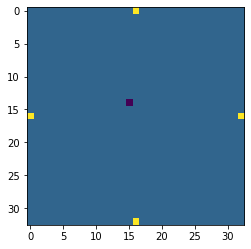

In [29]:
env.render()

In [30]:
# This section is used to visualize your learned policy
from torch import Tensor
output_i = np.zeros((33,33))
output_j = np.zeros((33,33))
output_i_m = np.zeros((33,33))
output_j_m = np.zeros((33,33))
value_ij = np.zeros((33,33))
for i in range(33):
    for j in range(33):
        states = Tensor(np.asarray([i,j])).float().unsqueeze(0)
        
        '''
        you need to revise the following line, 
        to fit your policy/network outputs
        '''
        action, value = policy(states)
        output_i[i,j] = action[0]
        output_j[i,j] = action[1]
        value_ij[i,j] = value
        
plt.figure(figsize= (5,5))
for i in range(33):
    for j in range(33):
        plt.arrow(j,-i,output_j[i,j],-output_i[i,j],head_width=0.2,shape='left')
xlim(-1,33)
ylim(-33,1)
yticks([2*i-32 for i in range(17)],[2*i for i in range(17)])
plt.xticks([])
plt.yticks([])

TypeError: 'TD3' object is not callable